In [10]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import VR_Model, optimize_lags
from sdice_model import SimplifiedDICE, ScenarioDICE
from portfolio import PortfolioOptimizer

In [11]:
# Instancia para limpiar y procesar los datos
climate_data = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx').clean_and_prepare_data()
economic_data = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
gray_a = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA']
green_a = ['NEE', 'FSLR', 'VWDRY', 'BEP']
assets = gray_a + green_a
benchmark = '^GSPC'
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

# Fusiona los datos
data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
e_eco_data = pd.merge(economic_data, climate_data, on='Date').iloc[:-1]

gray_data = all_data[gray_a]  
green_data = all_data[green_a]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


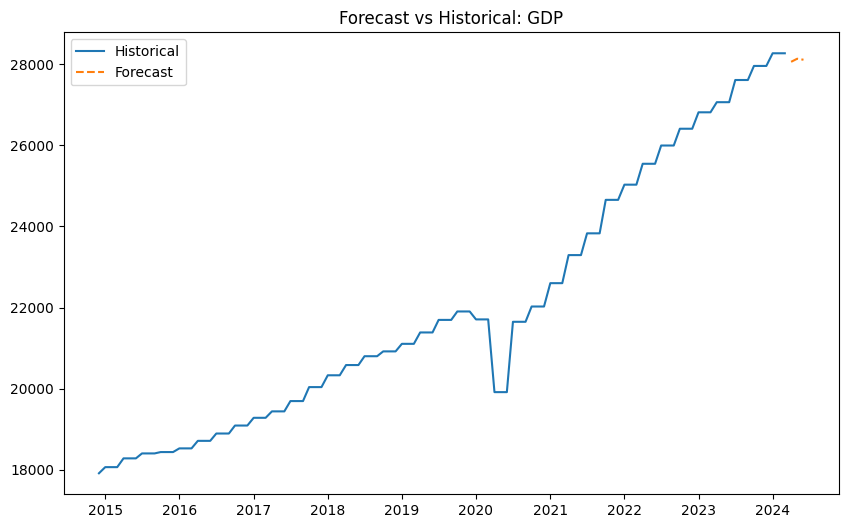

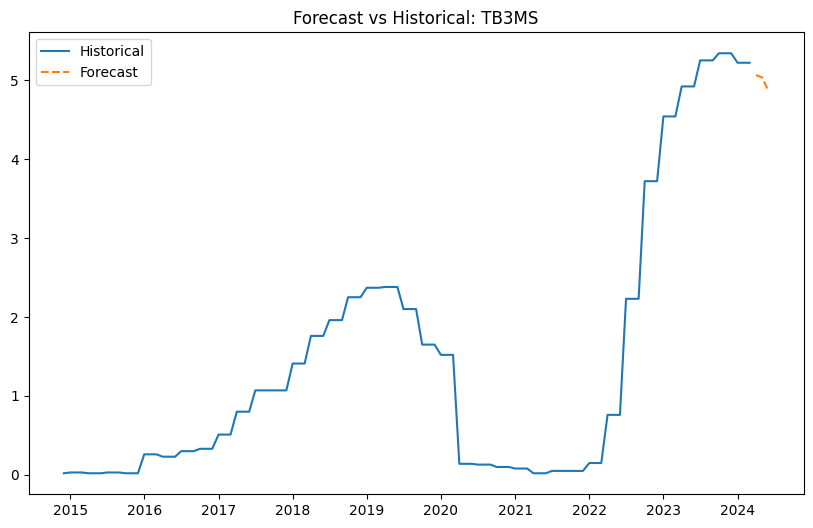

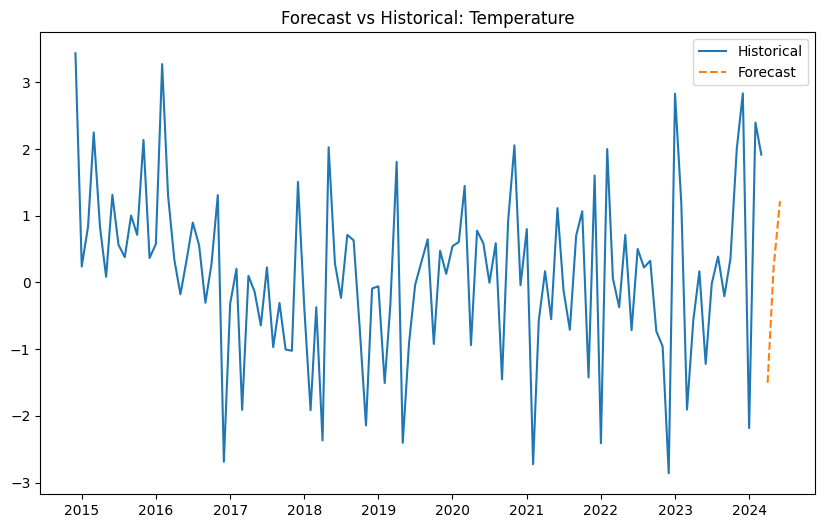

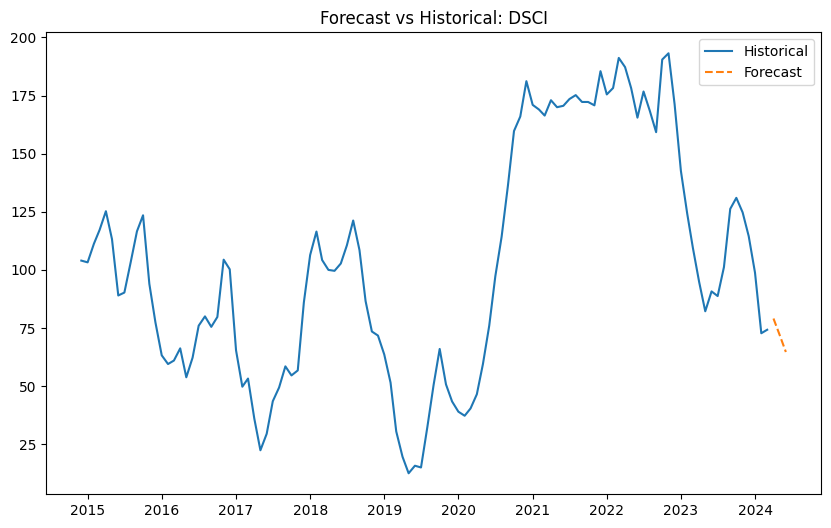

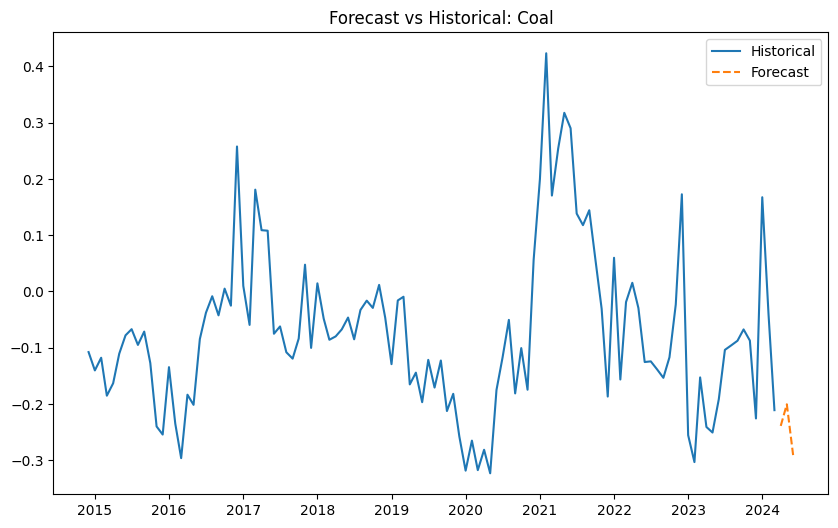

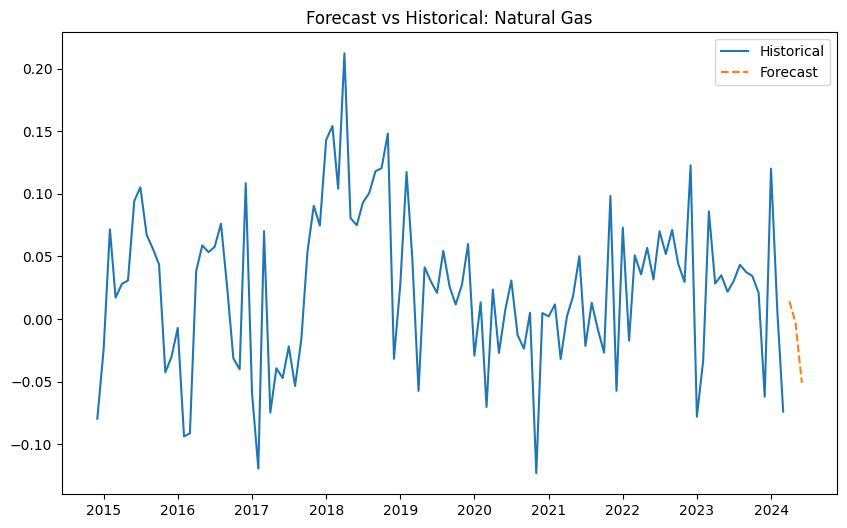

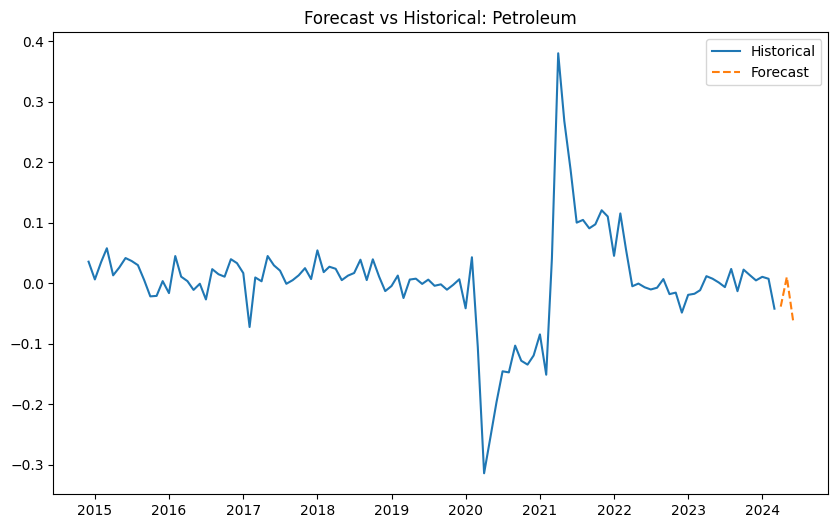

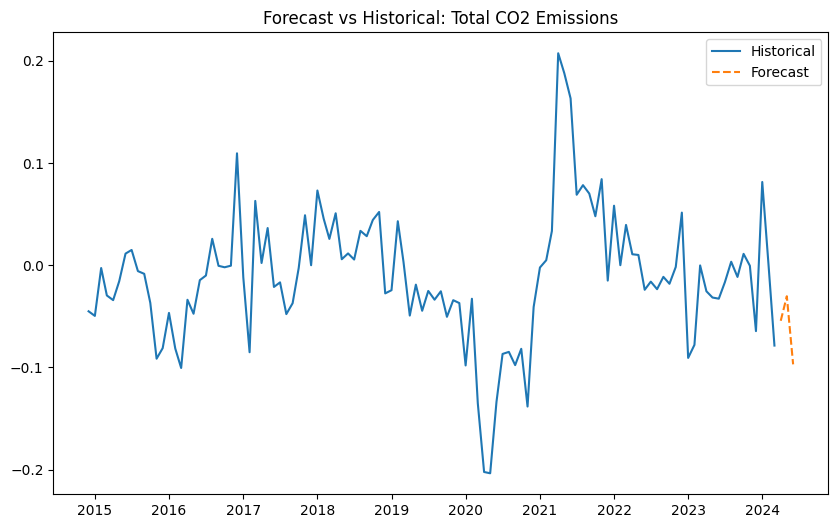

In [12]:
# Inicializar modelo
optimal_lags = optimize_lags(e_eco_data, trials=50)
vr_model = VR_Model(e_eco_data, optimal_lags)

# Ajustar el modelo y realizar predicciones
vr_model.fit()
vr_model.plot_predictions(steps=3)

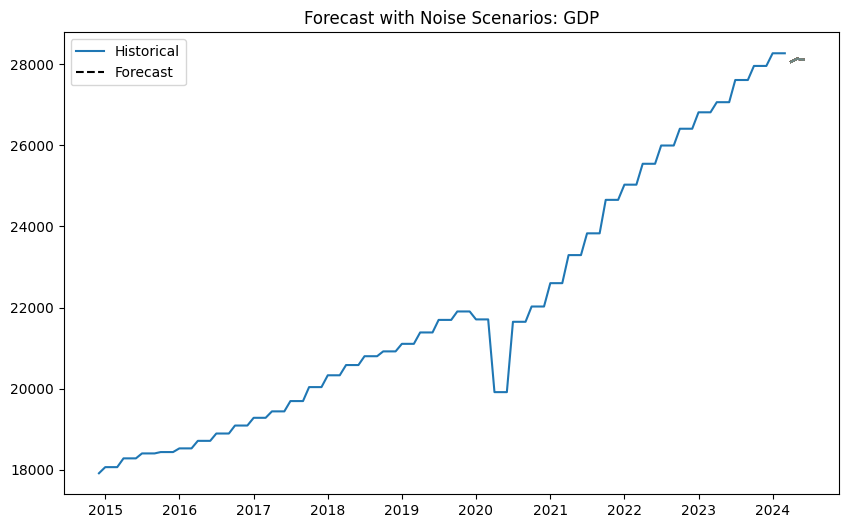

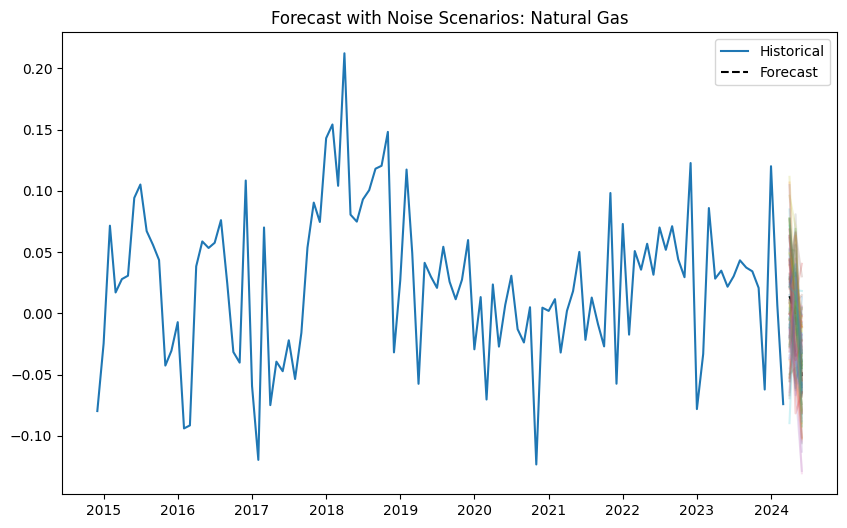

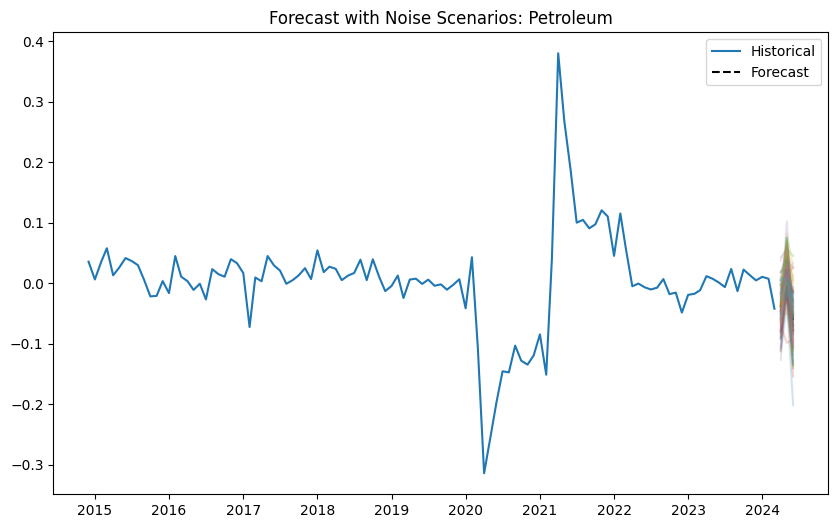

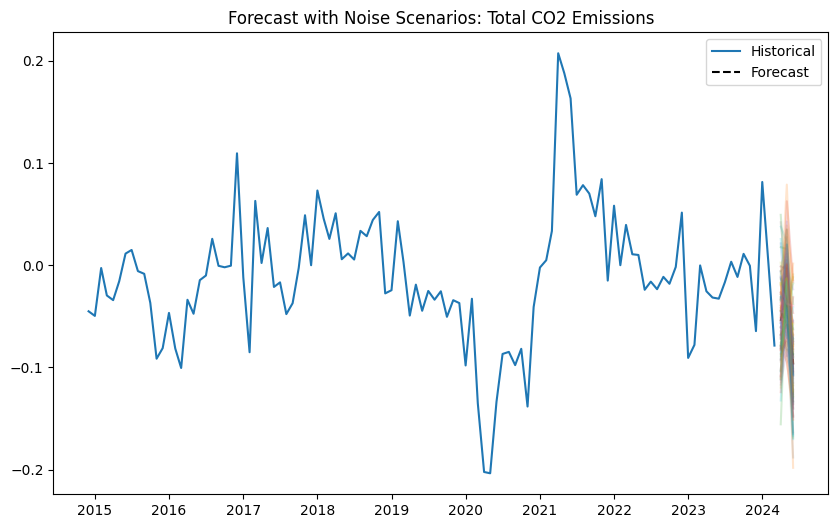

In [13]:
# Generar y graficar los escenarios con ruido
vr_model.generate_scenarios_with_noise(steps=3, n_scenarios=100)

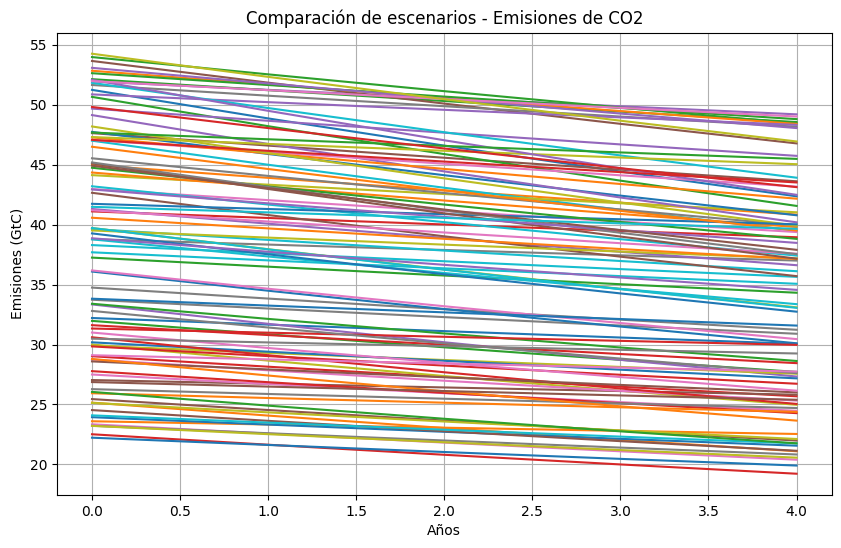

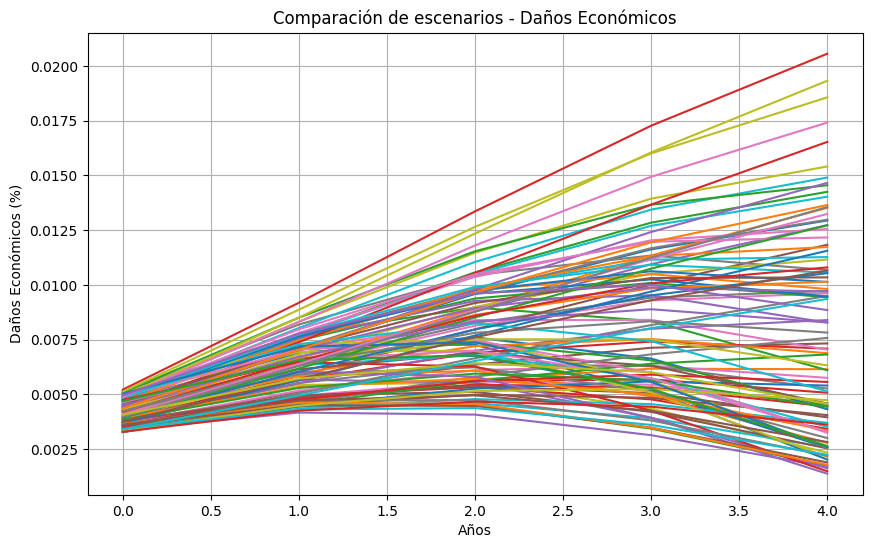

In [14]:
# Instanciar la clase ScenarioDICE
scenario_dice = ScenarioDICE()

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

economic_climate_vars = ['Temperature', 'DSCI', 'Coal', 'Natural Gas', 'Petroleum',
                         'Total CO2 Emissions', 'GDP', 'TB3MS', 'CPI']

aligned_data = all_data[economic_climate_vars].dropna()

aligned_data = aligned_data.loc[all_data.index]

# Inicializa un dataframe para almacenar las betas
betas_df = pd.DataFrame(index=gray_a + green_a, columns=economic_climate_vars)

# Calcula las betas de cada activo respecto a las demás variables
for asset in gray_a + green_a:
    # Prepara las variables dependientes e independientes
    X = aligned_data.values  # Variables económicas y climáticas
    y = all_data[asset].values  # Retornos del activo (ya están en all_data)

    # Ajusta un modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)

    # Almacena las betas en el dataframe
    betas_df.loc[asset] = model.coef_

betas_df



Temperature      DSCI      Coal Natural Gas Petroleum  \
AAPL     0.008777 -0.000051 -0.442633    -0.56396 -1.031285   
IBM     -0.004645  0.000164  0.209145    0.137488  0.415655   
TSLA     0.025597 -0.000595 -0.850727    -0.97392 -2.026972   
GOOG     0.009861 -0.000205  0.371654    0.335359  0.408169   
NVDA     0.026794 -0.000637 -0.512605   -0.831173 -1.243106   
NEE      0.000178 -0.000103 -0.299851   -0.380283  -0.54467   
FSLR       0.0218 -0.000015 -0.530892   -0.704204 -1.469721   
VWDRY    0.009615  0.000775 -0.001026   -0.236739 -0.320119   
BEP      0.003069  -0.00008 -0.290105   -0.409746  -0.62459   

      Total CO2 Emissions       GDP     TB3MS       CPI  
AAPL             1.926667  0.000017 -0.005865 -0.002418  
IBM             -0.954294  0.000003  0.008439 -0.000496  
TSLA             3.391758  0.000042 -0.044556 -0.003488  
GOOG            -1.184453   0.00001  0.001867 -0.001055  
NVDA             2.975888 -0.000043 -0.006814  0.006638  
NEE              1.139699  0.000023  -0.00609  -0.00316  
FSLR             2.635884 -0.000026 -0.013185  0.004077  
VWDRY            0.039238 -0.000008  0.026699 -0.001457  
BEP              0.973067   0.00004 -0.004831 -0.005496

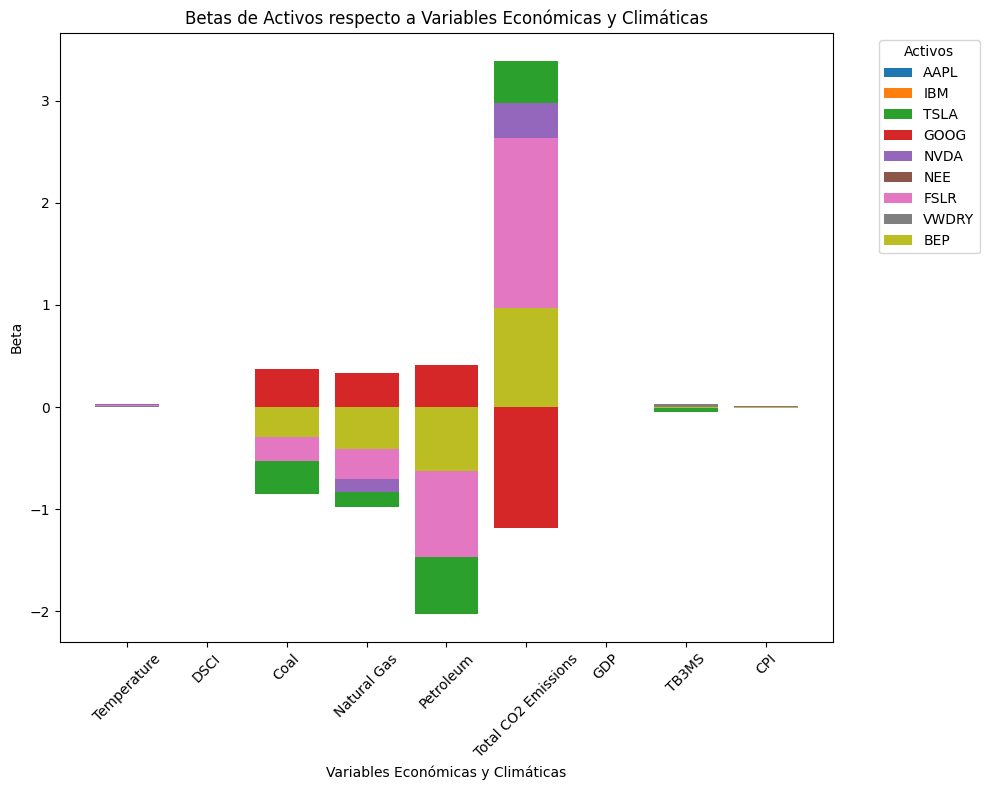

In [16]:
import matplotlib.pyplot as plt

# Creamos una figura y subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Para cada activo, graficamos las betas respecto a las variables
for asset in betas_df.index:
    ax.bar(betas_df.columns, betas_df.loc[asset], label=asset)

# Etiquetas y títulos
ax.set_title('Betas de Activos respecto a Variables Económicas y Climáticas')
ax.set_xlabel('Variables Económicas y Climáticas')
ax.set_ylabel('Beta')
ax.legend(title="Activos", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotar etiquetas del eje x para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

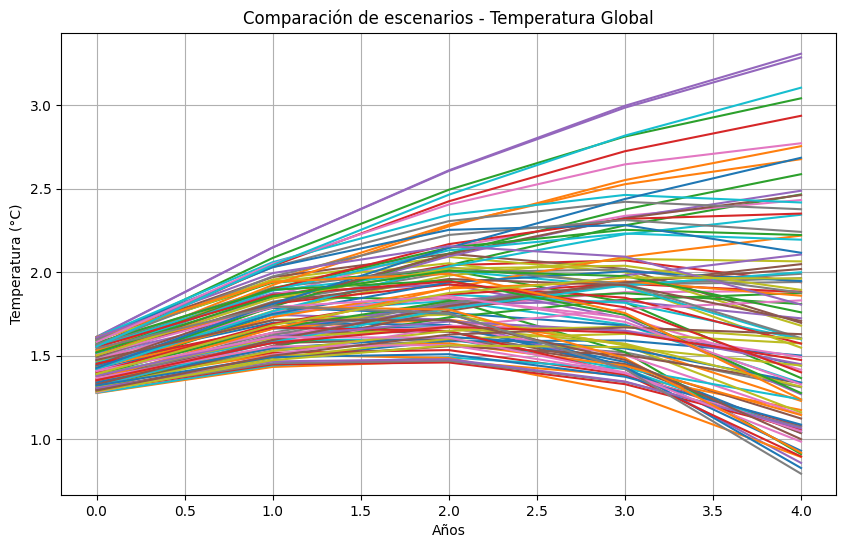

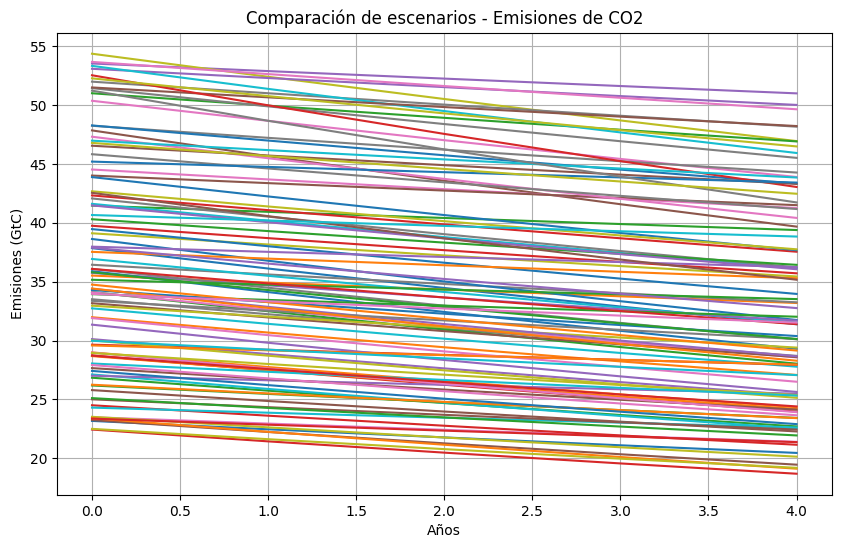

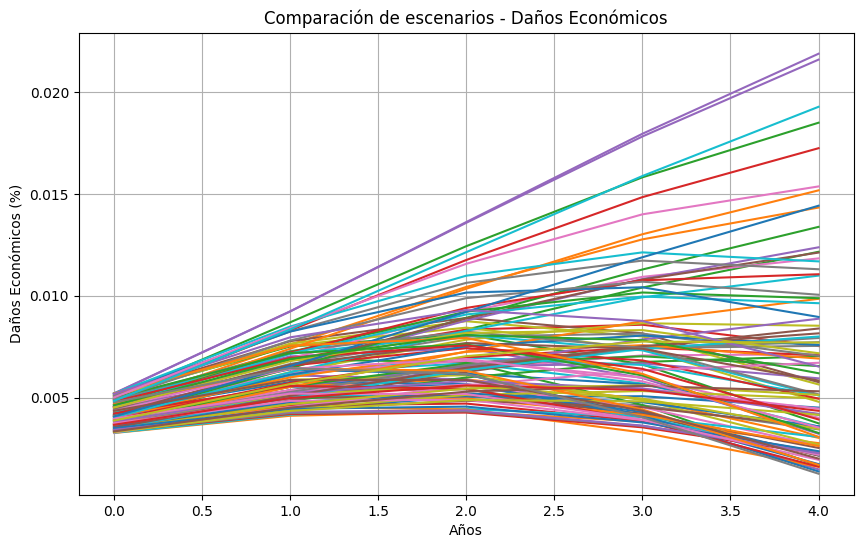


Retorno promedio del mejor portafolio: 217.0782


In [17]:
# Definir las variables económicas y climáticas
economic_factors = economic_data[['GDP', 'TB3MS', 'CPI']]  # Selecciona las columnas económicas que te interesan
climate_factors = climate_data[['Temperature', 'DSCI', 'Coal', 'Natural Gas', 'Petroleum', 'Total CO2 Emissions']]  # Selecciona las columnas climáticas

# Inicializar modelo VAR con los datos económicos y climáticos (e_eco_data)
optimal_lags = optimize_lags(e_eco_data, trials=50)
vr_model = VR_Model(e_eco_data, optimal_lags)

# Ajustar el modelo VAR
vr_model.fit()

# Obtener las predicciones del VAR para los próximos 3 periodos
var_predictions = vr_model.predict(steps=3)

# Inicializar optimizador de portafolios
optimizer = PortfolioOptimizer(
    asset_prices=asset_prices,
    risk_free_rate=rf,
    benchmark_prices=benchmark_prices,
    economic_factors=economic_factors,  # Datos económicos procesados
    climate_factors=climate_factors,    # Datos climáticos procesados
    betas=betas_df                      # Matriz de betas que has calculado
)

# Optimizar los portafolios con múltiples estrategias
optimal_portfolios, portfolios_df = optimizer.optimize_with_multiple_strategies(
    strategies=['sharpe', 'omega', 'sortino'],
    gray_assets=gray_a,
    green_assets=green_a
)

# Calcular los expected returns ajustados usando las predicciones del modelo VAR
portfolios_df = optimizer.calculate_portfolio_expected_returns(portfolios_df, var_predictions)

# Mostrar los portafolios con los expected returns calculados
print(portfolios_df)

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

# Buscar el portafolio con el mejor score
best_portfolio = portfolios_df.loc[portfolios_df['metric_score'].idxmax()]

# Calcular el retorno promedio del mejor portafolio
average_return = np.mean(best_portfolio['expected_return'])

# Imprimir el mejor portafolio con su retorno promedio
print(f"\nRetorno promedio del mejor portafolio: {average_return:.4f}")
